# Spatial Data - Baseline Methods + Cellcharter

In this notebook we will go through two reowned ways of modelling of cellular neighborhoods:

- mean marker representation,
- cell type histogram representation.

In this notebook you will:
- compute appropriate neighborhood-enriched cell representations,
- perform an EDA based on this representations,
- compare them with a [Cellcharter](https://www.nature.com/articles/s41588-023-01588-4) method.

Let's start with installing appropriate package instalation:
- be sure that you are using GPU backend on colab,
- restart session after the installation.

In [1]:
!pip install squidpy
!pip install cellcharter

Make sure that the following import runs correctly without error (ignore legacy / future warnings):

In [2]:
import cellcharter

/usr/lib/python3.11/importlib/__init__.py:126: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  return _bootstrap._gcd_import(name[level:], package, level)
/usr/local/lib/python3.11/dist-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


Once again - set up your data as in previous exercise:

In [3]:
import anndata

from google.colab import drive
drive.mount('/content/drive')

TRAIN_ANNDATA_PATH = '/content/drive/MyDrive/train_adata.h5ad'


train_anndata = anndata.read_h5ad(TRAIN_ANNDATA_PATH)
train_anndata

Mounted at /content/drive


AnnData object with n_obs × n_vars = 253433 × 40
    obs: 'image', 'sample_id', 'ObjectNumber', 'Pos_X', 'Pos_Y', 'area', 'major_axis_length', 'minor_axis_length', 'eccentricity', 'width_px', 'height_px', 'acquisition_id', 'SlideId', 'Study', 'Box.Description', 'Position', 'SampleId', 'Indication', 'BatchId', 'SubBatchId', 'ROI', 'ROIonSlide', 'includeImage', 'flag_no_cells', 'flag_no_ROI', 'flag_total_area', 'flag_percent_covered', 'small_cell', 'celltypes', 'flag_tumor', 'PD1_pos', 'Ki67_pos', 'cleavedPARP_pos', 'GrzB_pos', 'tumor_patches', 'distToCells', 'CD20_patches', 'Batch', 'cell_labels', 'classifier'
    var: 'channel', 'use_channel', 'marker'
    layers: 'exprs'

The following code setups the data to the [`squidpy`](https://squidpy.readthedocs.io/en/stable/) format:

In [4]:
import squidpy as sq


train_anndata.obsm['spatial'] = train_anndata.obs[['Pos_X', 'Pos_Y']].values
sq.gr.spatial_neighbors(train_anndata, library_key='sample_id', coord_type='generic', delaunay=True, spatial_key='spatial', percentile=99)


The `spatial_neighbors` function from `squidpy` enriched the initial `train_adata` with the information about which cells neighbors each other. Let's inspect the following code:

In [5]:
train_anndata.obsp['spatial_connectivities'][0].indices

array([ 2,  6,  7, 10, 28, 32, 38], dtype=int32)

it provides you with the indices of the neighbors of `0` cell. Now using this information compute for each cell:

- an average marker expression of all cells in its neighborhood,
- a histogram of counts of each cell type in its neighborhoods. Histogram here means a vector of counts.

Store this information in an array that is ordered the same as `train_anndata.obs` cells.

Prepare an EDA analysis that will:
- run a `PCA` on each representation. `PCA` should explain `90%` of variance,
- similarly to a previous exercise, plot a `sns.clustermap` of the components.

For cell type histogram perform an analysis on both original counts, and [Hellinger](https://en.wikipedia.org/wiki/Hellinger_distance)-transformed ones (Hellinger here means an elementwise square-root transformation).

In [6]:
import pandas as pd
import numpy as np

# averge marker expression of all cells in a neighborhood

avg_marker_exps = []
for i in range(train_anndata.obs.shape[0]):
  neigh = train_anndata.obsp['spatial_connectivities'][i].indices
  neigh = list(neigh)
  neigh.append(i)
  expr = train_anndata.layers['exprs'][neigh]
  gene_expression_mean = np.mean(expr, axis=0)
  avg_marker_exps.append(gene_expression_mean)

avg_marker_exps = np.stack(avg_marker_exps)

train_anndata.obsm['avg_marker_exps'] = avg_marker_exps

In [7]:
# histogram of counts of each cell type in a neighborhood

train_anndata.obs['dummy'] = 1
celltype_onehosts = pd.pivot_table(train_anndata.obs, values='dummy',
  index=train_anndata.obs.index, columns=['celltypes'], aggfunc = np.sum)
celltype_onehosts = celltype_onehosts.loc[train_anndata.obs.index]


celltype_hist = []
for i in range(train_anndata.obs.shape[0]):
  neigh = train_anndata.obsp['spatial_connectivities'][i].indices
  neigh = list(neigh)
  neigh.append(i)
  neigh_celltype = celltype_onehosts.iloc[neigh]
  sum_neigh_celltype = np.sum(neigh_celltype, axis=0)
  celltype_hist.append(sum_neigh_celltype)

celltype_hist = np.stack(celltype_hist)
train_anndata.obsm['celltype_hists'] = celltype_hist
train_anndata.obsm['celltype_hists']


<ipython-input-7-cf5b74b266df>:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  celltype_onehosts = pd.pivot_table(train_anndata.obs, values='dummy',
<ipython-input-7-cf5b74b266df>:4: FutureWarning: The provided callable <function sum at 0x7cb1ec78a7a0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  celltype_onehosts = pd.pivot_table(train_anndata.obs, values='dummy',


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 2, 0, 0],
       [0, 0, 2, ..., 0, 0, 0],
       [0, 0, 0, ..., 5, 0, 0]])

Now - let's perform a clustering of each representation. For this we will use [`Cellcharter`](https://cellcharter.readthedocs.io/en/stable/generated/cellcharter.tl.ClusterAutoK.html#) function [`ClusterAutoK`](https://cellcharter.readthedocs.io/en/stable/generated/cellcharter.tl.ClusterAutoK.html#) that determines the number of clusters. Your task consists of the following steps:

- read the [documentation](https://cellcharter.readthedocs.io/en/stable/generated/cellcharter.tl.ClusterAutoK.html#) of the method,
- enrich the `train_anndata.obsm` with both mean marker and cell type histogram representations,
- using example from the documentation, setup appropriate cluster selectors with a `gpu` backend for both of the modalities. Cluster selection shoud try number of clusters from range 10 to 30,
- run the cluster selection on the representations. In order to speed up computations you can downsample the table by a factor of 10 or 20,
- plot the cluster selection results using a provided `cellcharter` [function](https://cellcharter.readthedocs.io/en/latest/generated/cellcharter.pl.autok_stability.html) and analyze the results,
- for both modalities, select number of clusters and compute appropriate predictions. Store them in the `train_anndata`. Which field of the `anndata` suits this data the most?
- for both modalities, compute the average cell type abundance and average marker expressions for each cluster.

In [8]:
import cellcharter as cc
import scanpy as sc

### Clustering ###

train_anndata.obsm['avg_marker_exps'] = train_anndata.obsm['avg_marker_exps'].astype(np.float32)
train_anndata.obsm['celltype_hists']=train_anndata.obsm['celltype_hists'].astype(np.float32)

# Setup cluster selectors
model_params = {
        'random_state': 42,
        'trainer_params': {
            'accelerator':'gpu',
            'enable_progress_bar': False
        },
    }


In [9]:
# model for markers
model_avg_marker_exps = cc.tl.ClusterAutoK(
    n_clusters=range(10,30), model_class=cc.tl.GaussianMixture,
    model_params=model_params, max_runs=5)


model_avg_marker_exps.fit(train_anndata[::20], use_rep='avg_marker_exps')

Iteration 1/5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 2/5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 3/5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 4/5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 5/5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Najlepsza liczba klastrów:26


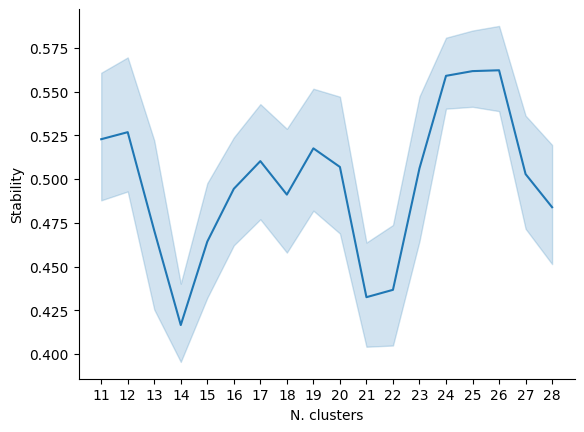

In [10]:
print(f'Najlepsza liczba klastrów:{model_avg_marker_exps.best_k}')
cellcharter.pl.autok_stability(model_avg_marker_exps)

In [11]:
train_anndata.obs['clusters_avg_marker_exps'] = model_avg_marker_exps.predict(train_anndata, use_rep='avg_marker_exps', k=model_avg_marker_exps.best_k)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [12]:
# model for histograms
model_celltype_hists = cc.tl.ClusterAutoK(
    n_clusters=range(10,30), model_class=cc.tl.GaussianMixture,
    model_params=model_params, max_runs=5)
model_celltype_hists.fit(train_anndata[::20], use_rep='celltype_hists')


Iteration 1/5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 2/5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 3/5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 4/5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 5/5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Najlepsza liczba klastrów:12


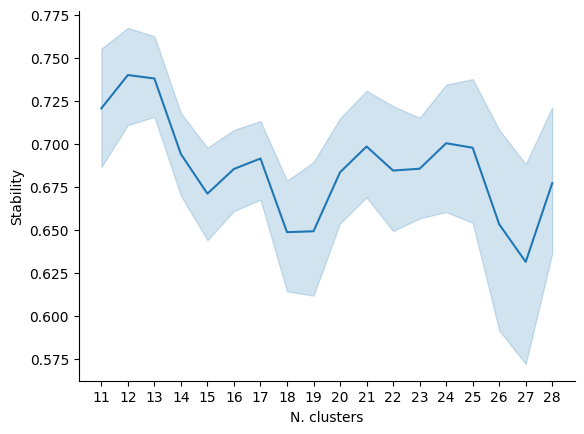

In [13]:
print(f'Najlepsza liczba klastrów:{model_celltype_hists.best_k}')
cellcharter.pl.autok_stability(model_celltype_hists)

In [14]:
train_anndata.obs['clusters_hists'] = model_celltype_hists.predict(train_anndata, use_rep='celltype_hists', k=model_celltype_hists.best_k)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


## Homework - PROJECT 3:

As your homework, you will use a `Cellcharter` to compute the cellular neighborhood representation, and later - analyze them. The task is inspired by [this](https://cellcharter.readthedocs.io/en/stable/notebooks/cosmx_human_nsclc.html) tutorial, so we highly recommend to go through it before jumping into coding the solution.

Your task consists of the following step:
- (warm up) - once again perform a `PCA` on cells marker expressions. Your `PCA` should explain 95% of markers variance. Store a `PCA` transformed marker expressions in `train_anndata.obsm["X_PCA"]` field (note: this is equivalent to `"X_SCVI"` field from the tutorial) - 1pt,
- perform a `cellcharter` neighbor aggregation using [this](https://cellcharter.readthedocs.io/en/latest/generated/cellcharter.gr.aggregate_neighbors.html#cellcharter.gr.aggregate_neighbors) function (hint: `sample_key` for our data is `sample_id`). Select `n_layers` parameter value on your own, but shortly explain your choice - 2pts,
- perform a cluster selection in the same manner as for mean marker and cell type histogram representation - 2pts,
- perform a `PCA`, celltype abundance and mean marker analysis in the same manner as for mean marker and cell type histogram representations - 3pts,
- for each pair of the clusterings out of mean marker, cell type histogram and cellcharter-based ones, compute a cross-count matrix (a cross-count matrix stores the information about how many times each cell was assigned to a predefined pair of clusters from every modality). Visualize these matrices and briefly explain the results - 2pts.

In this task you do not need to prepare a proper report, inline comments in the notebook are sufficient. However, make sure that you comment on any of the steps, decisions or results. As usual, we want to make sure that we are able _to understand_ our results.

The deadline for the task: 12th May, 12:00 (noon)
Have fun!


In [15]:
import scanpy as sc
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
### 1. PCA on cell's marker expression ###

# Count sum of expression for each cell
cell_sums = train_anndata.layers['exprs'].sum(axis=1)

# Normalize so that the total expression per cell sums to 1e6
target_sum = 1e6
train_anndata.layers['exprs_norm'] = train_anndata.layers['exprs'] / cell_sums[:, np.newaxis] * target_sum

# PCA
pca = PCA(n_components = 0.95, svd_solver='full')
pca.fit(train_anndata.layers['exprs_norm'])
print(pca.explained_variance_ratio_)
train_anndata.obsm['X_PCA'] = pca.transform(train_anndata.layers['exprs_norm'])



[0.2424895  0.14461852 0.10366809 0.07871985 0.05652588 0.05475299
 0.04017148 0.02998578 0.02725376 0.02242551 0.0175516  0.01608009
 0.01432176 0.01375784 0.01316469 0.01211166 0.01116847 0.01012779
 0.00915781 0.00890646 0.0082446  0.00765198 0.00677391 0.00673813]


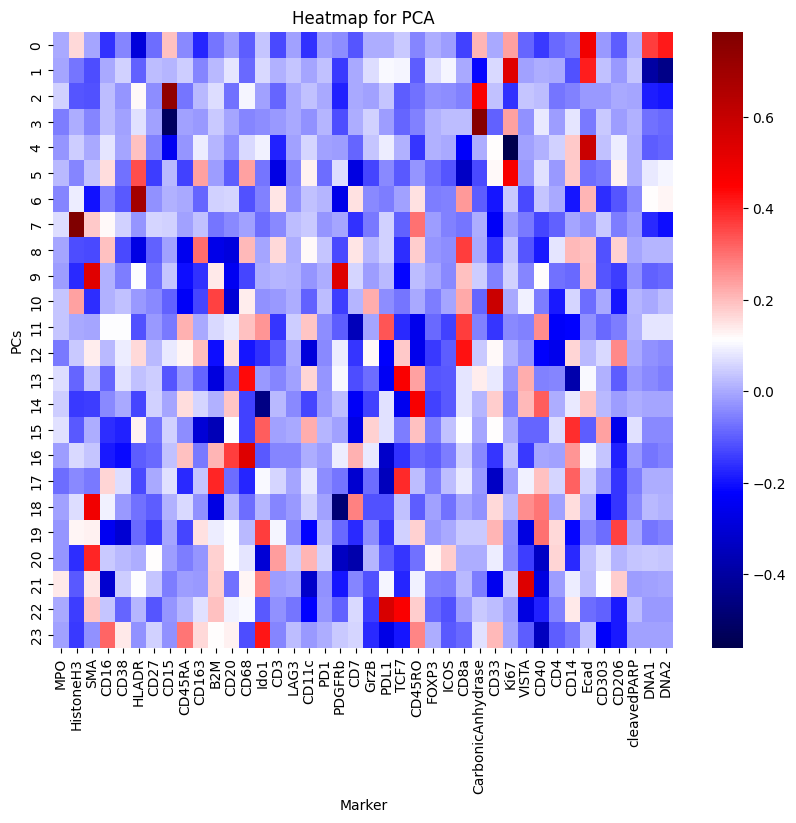

In [31]:
plt.figure(figsize=(10, 8))
sns.heatmap(pca.components_, cmap="seismic", xticklabels=train_anndata.var['marker'])
plt.title(f'Heatmap for PCA')
plt.xlabel('Marker')
plt.ylabel('PCs')
plt.show()

95% of the variance in the cells' marker expression is explained by 23 principal components. The markers contribute differently to these components; for instance, the strongest influences on the PCs are HistoneH3, CD15, and Carbonic Anhydrase.

In [32]:
### 2. Neighbor aggregation ###

cc.gr.aggregate_neighbors(
    train_anndata,
    n_layers=2,
    use_rep='X_PCA',
    sample_key = 'sample_id'
)



  0%|          | 0/132 [00:00<?, ?it/s]

Setting n_layers to 2 includes 2-hop neighbors, which allows to investigate the closest, local environment of the cell and focus on the neighbors it is most likely to interact with.

In [33]:
### 3. Cluster selection ###

model_cellcharter = cc.tl.ClusterAutoK(
    n_clusters=range(10,30), model_class=cc.tl.GaussianMixture,
    model_params=model_params, max_runs=5)


model_cellcharter.fit(train_anndata[::20], use_rep='X_cellcharter')

Iteration 1/5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 2/5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 3/5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 4/5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 5/5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Najlepsza liczba klastrów: 17


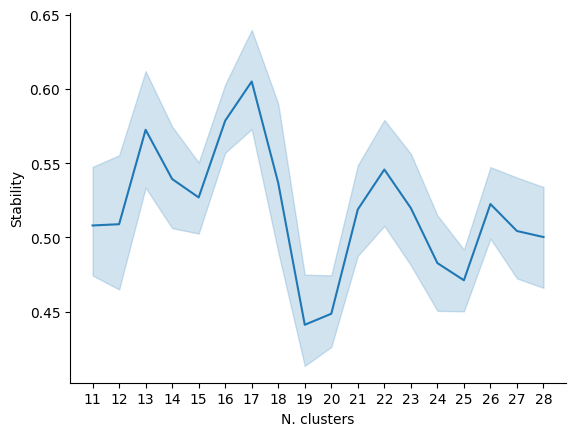

In [34]:
print(f'Najlepsza liczba klastrów: {model_cellcharter.best_k}')
cellcharter.pl.autok_stability(model_cellcharter)

In [35]:
train_anndata.obs['clusters_cellcharter'] = model_cellcharter.predict(train_anndata, use_rep='X_cellcharter', k=model_cellcharter.best_k)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


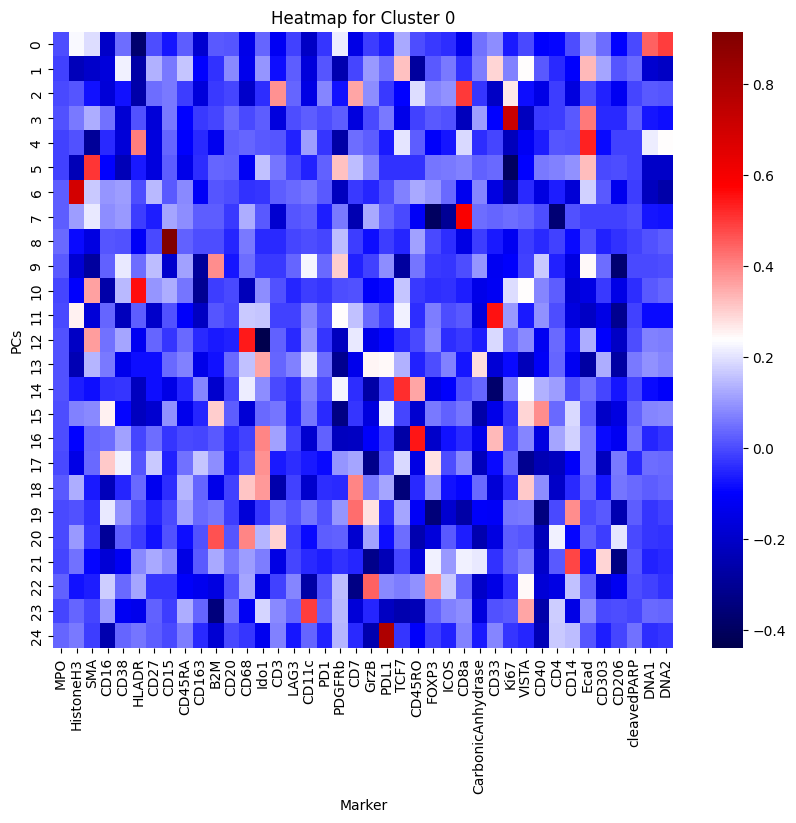

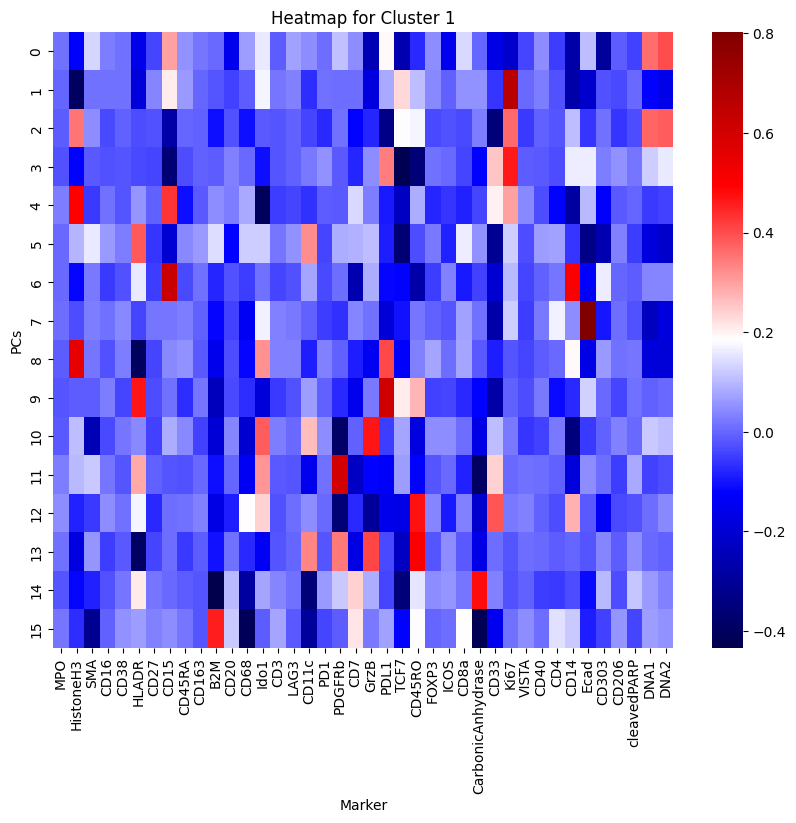

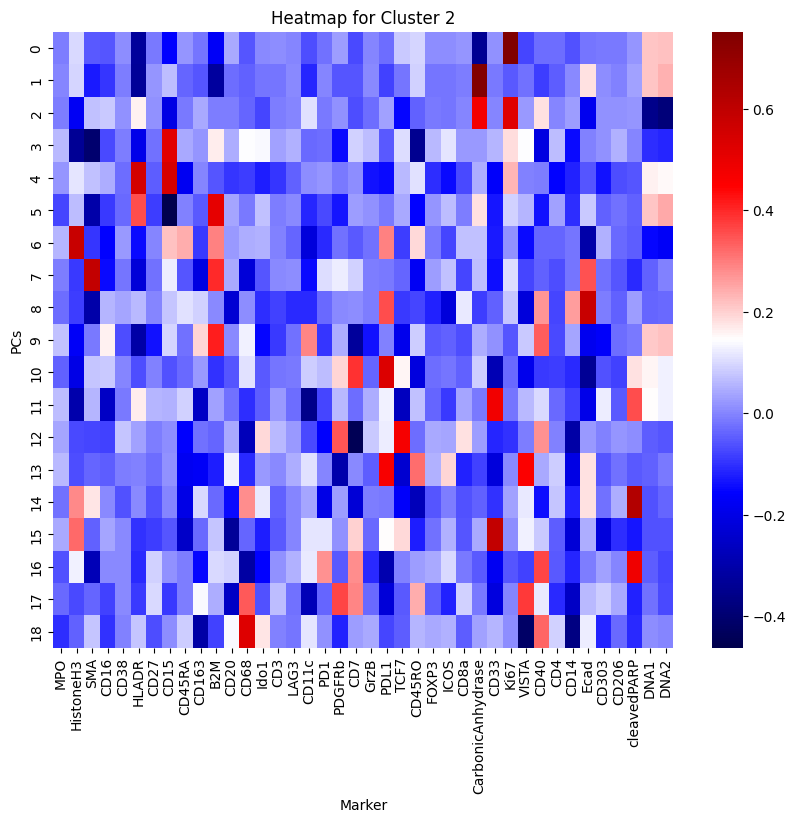

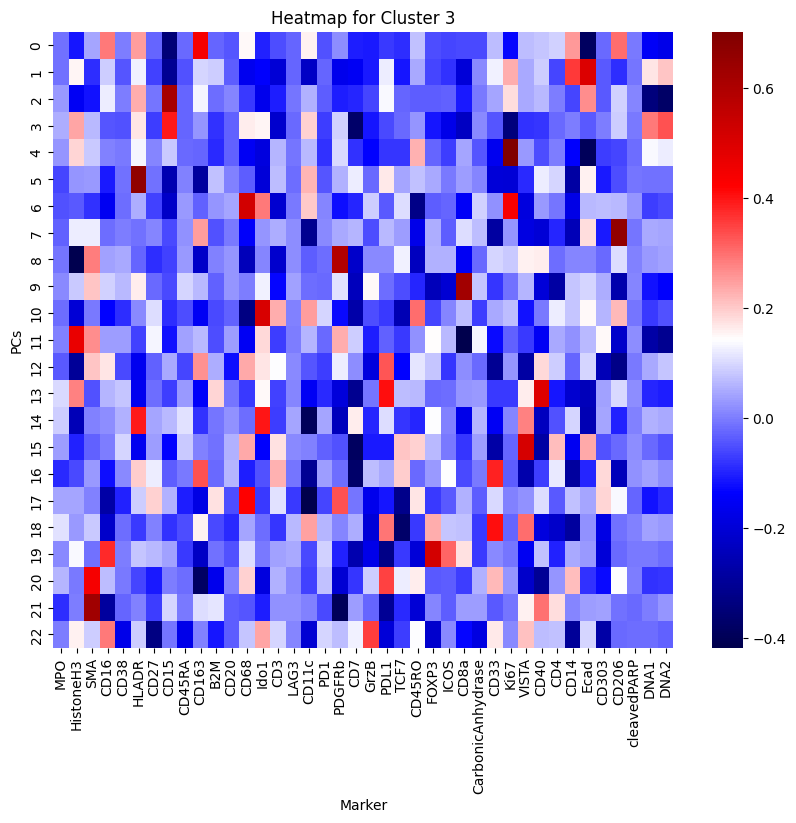

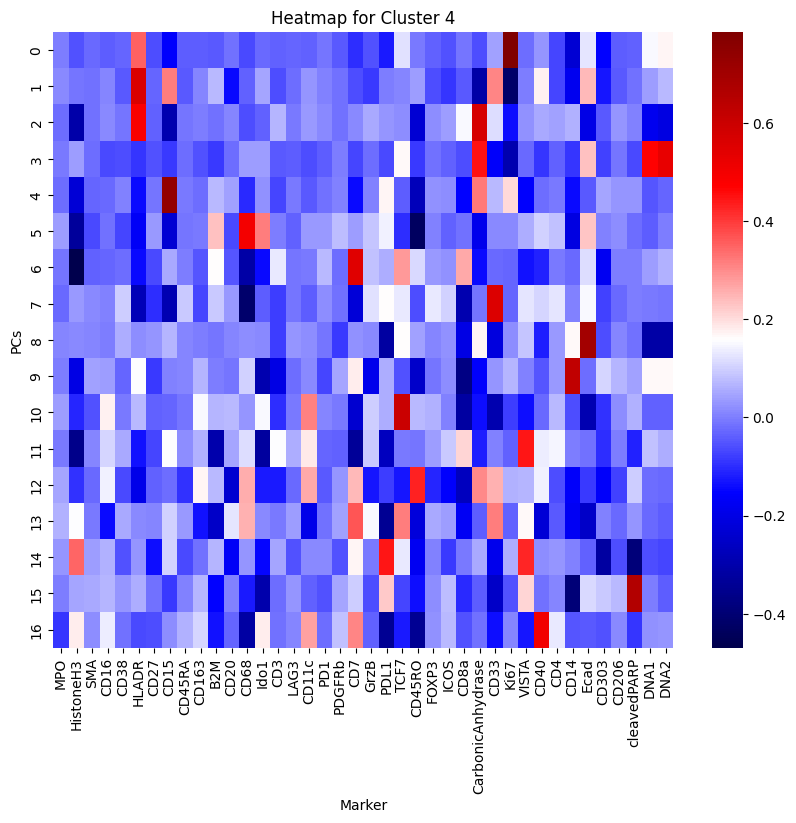

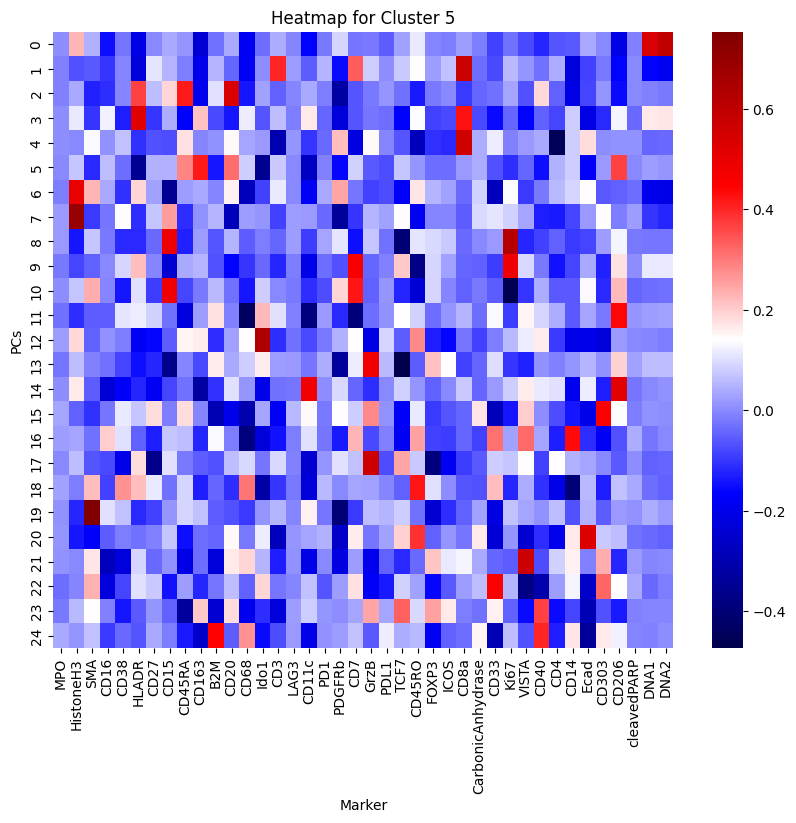

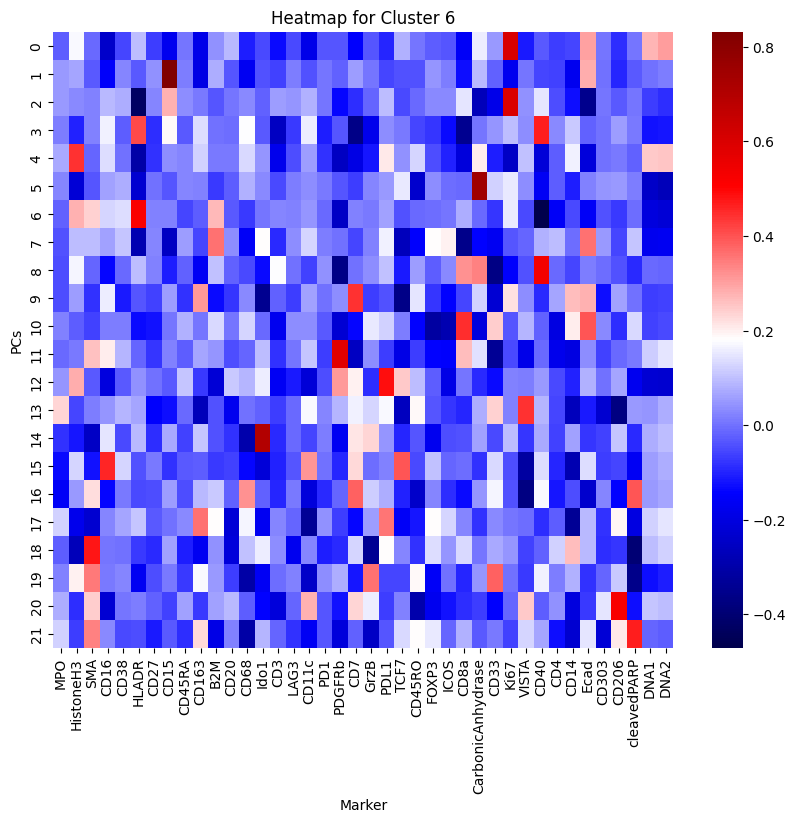

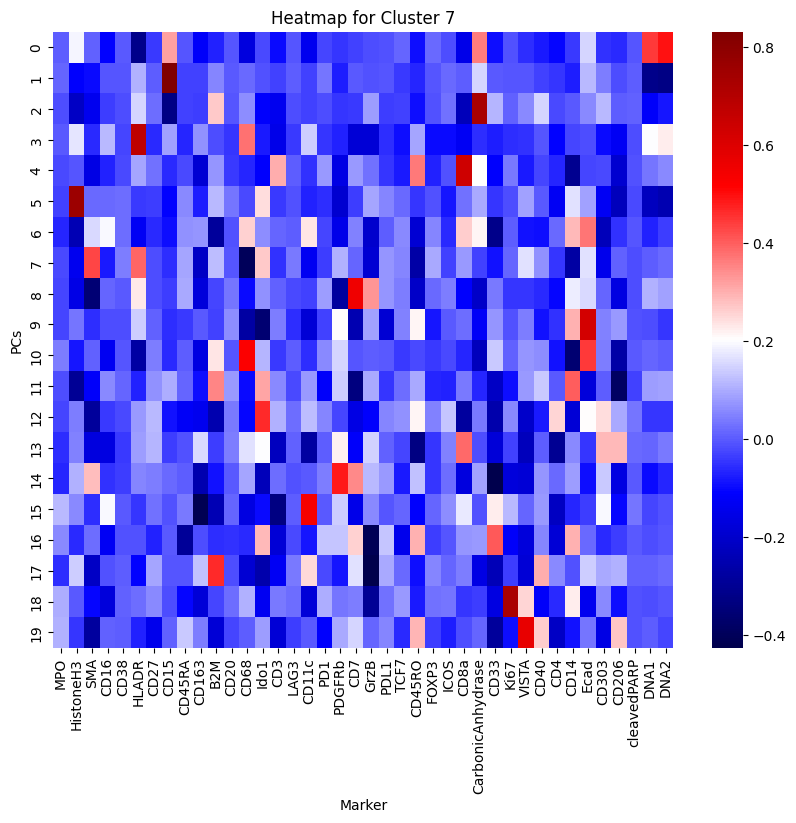

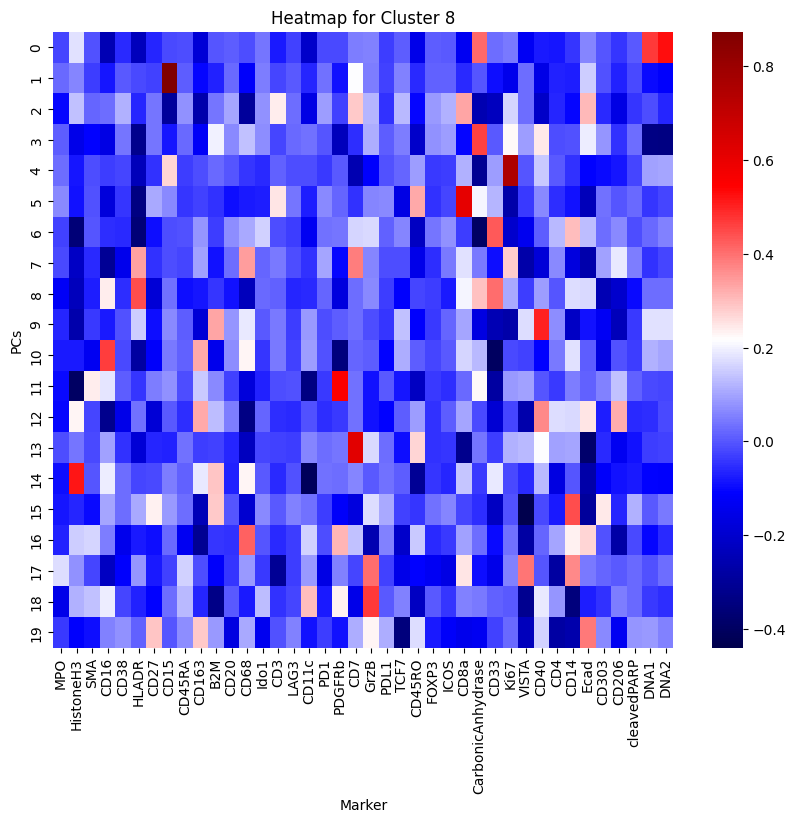

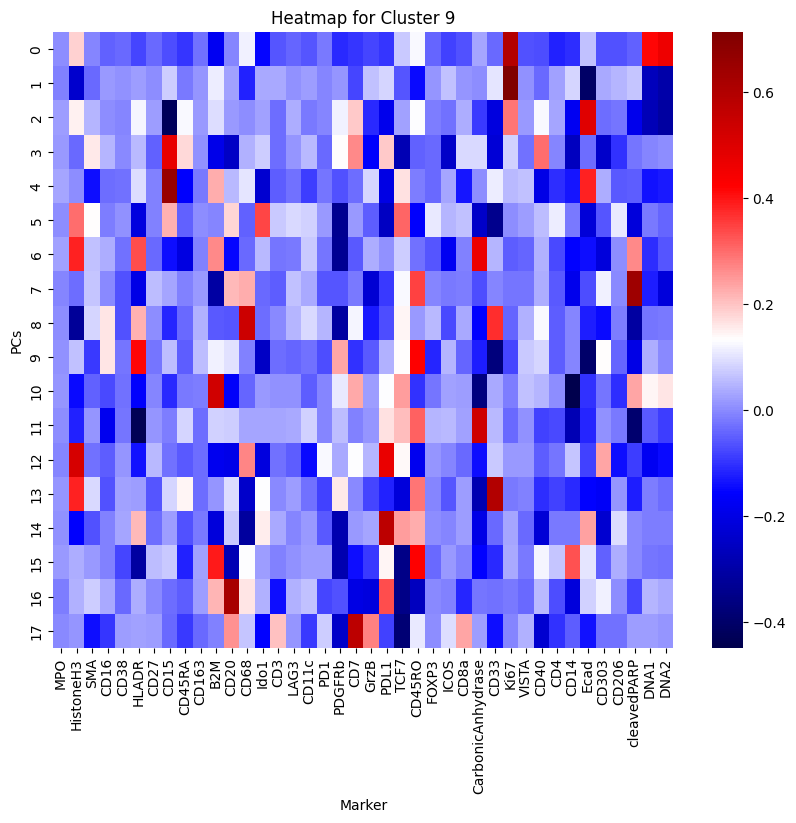

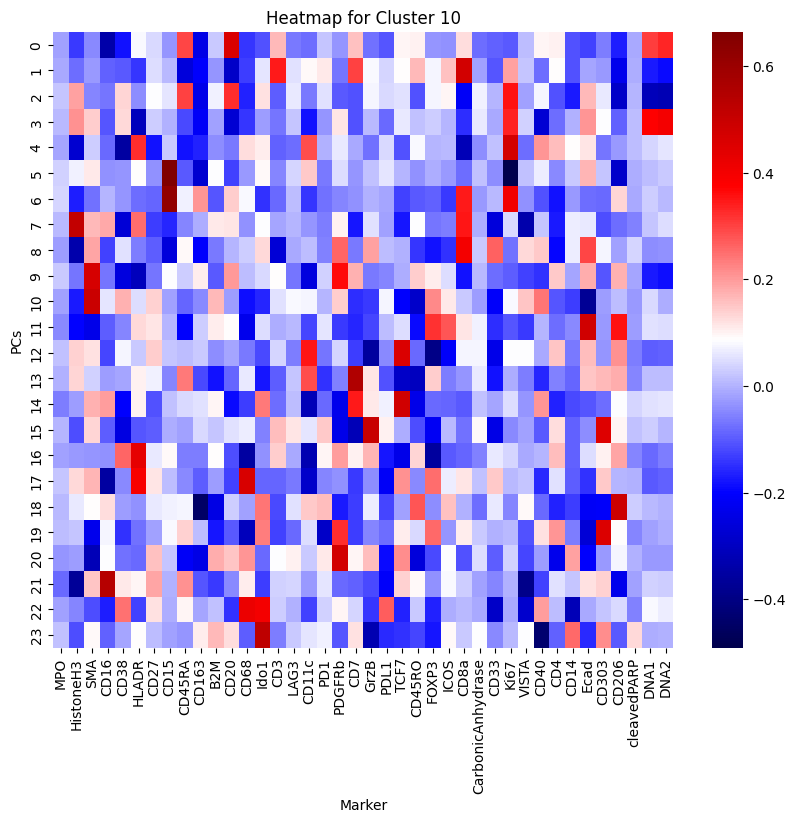

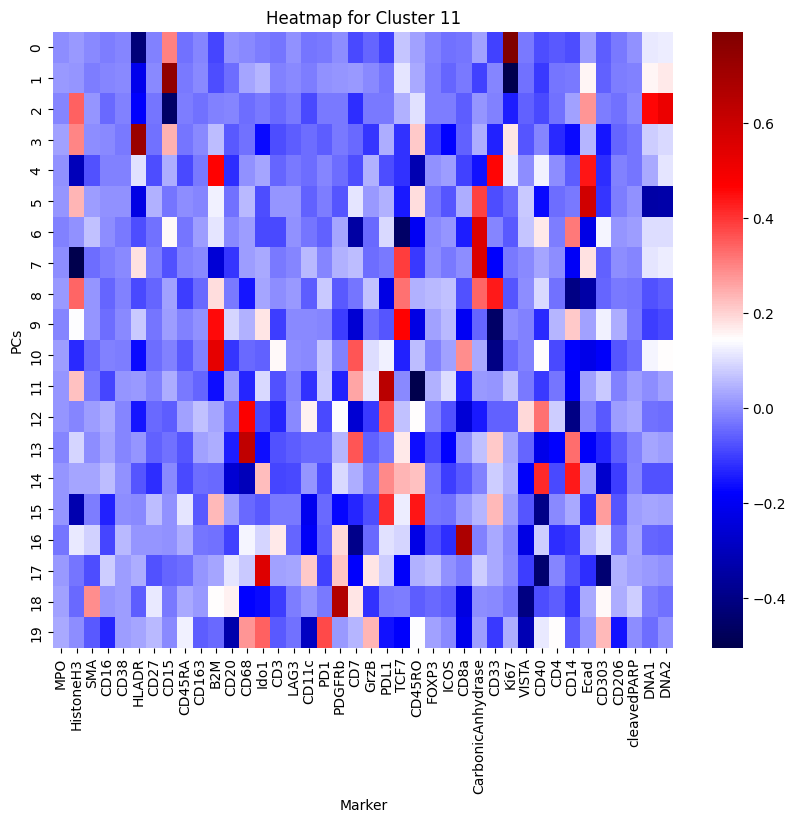

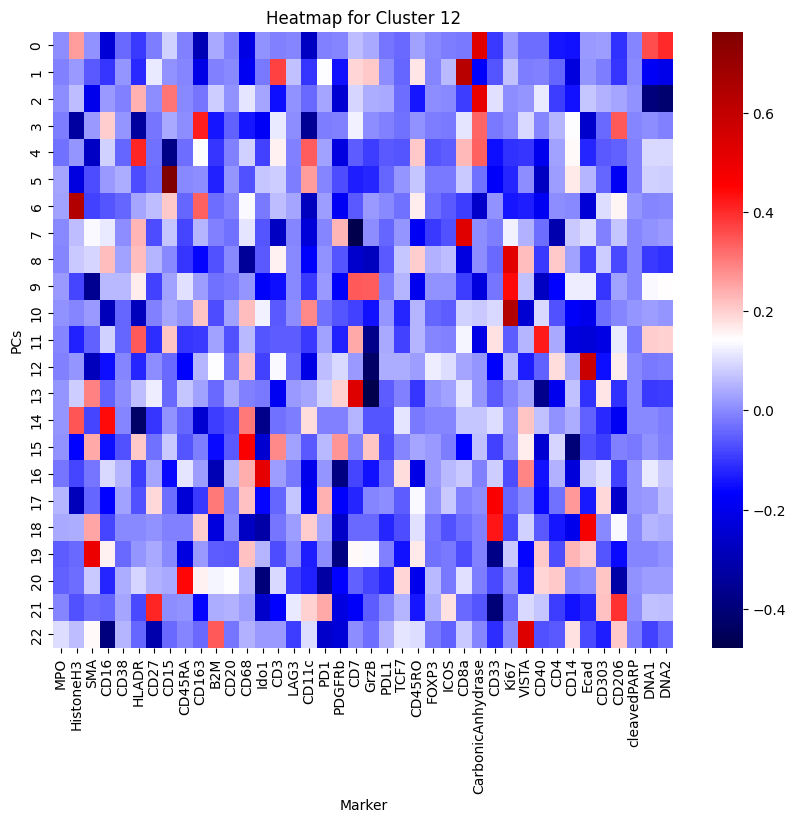

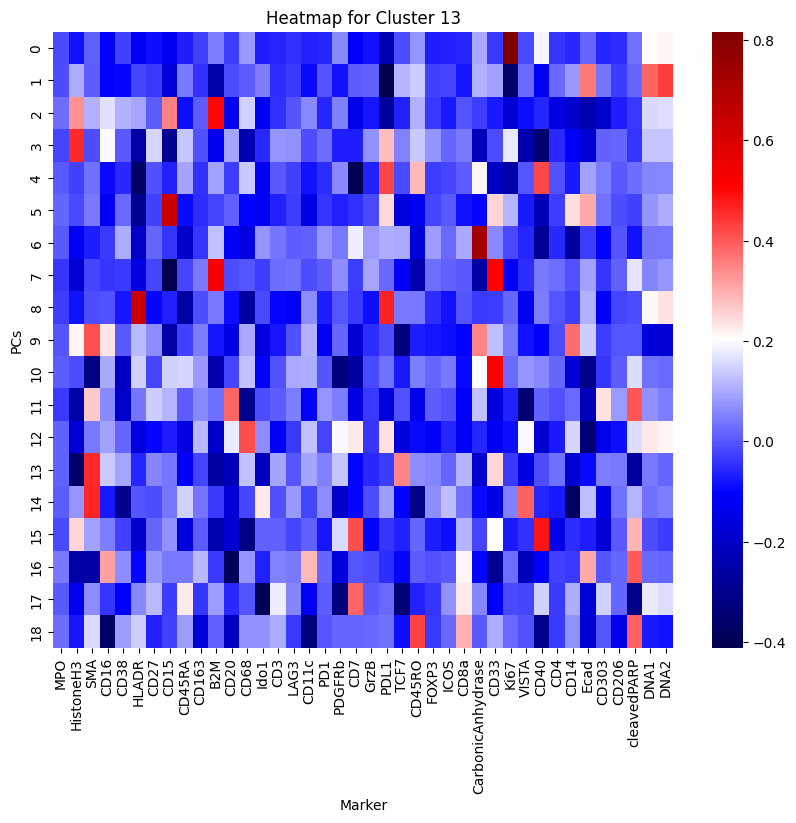

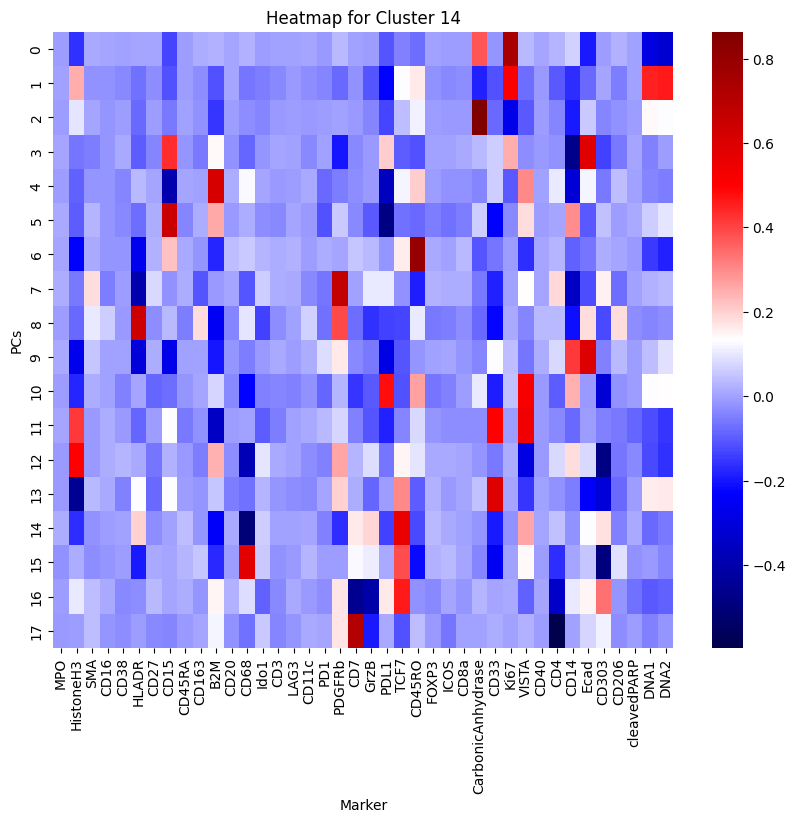

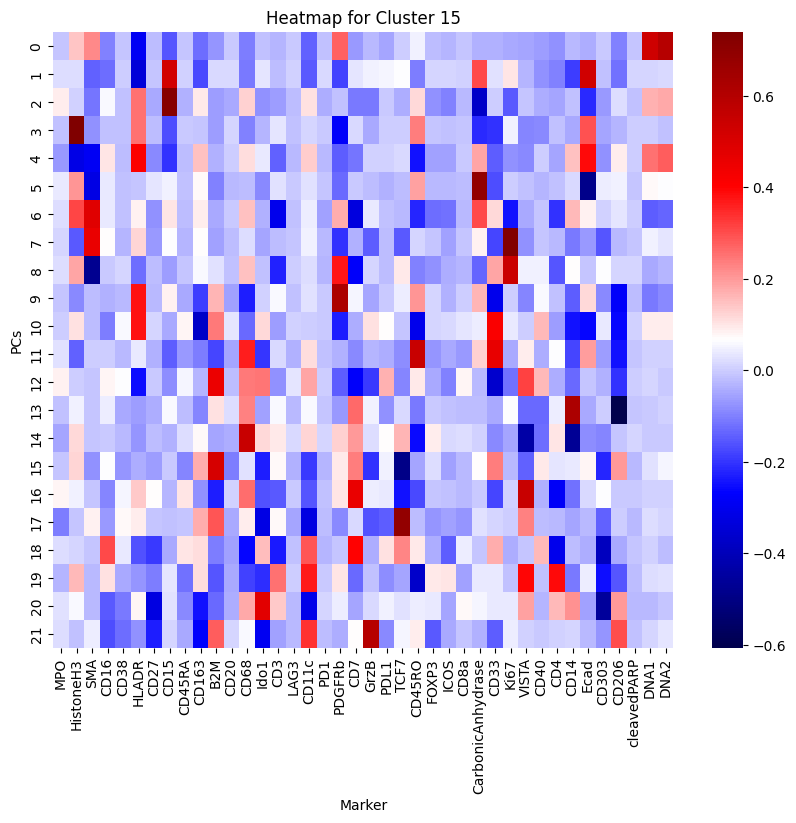

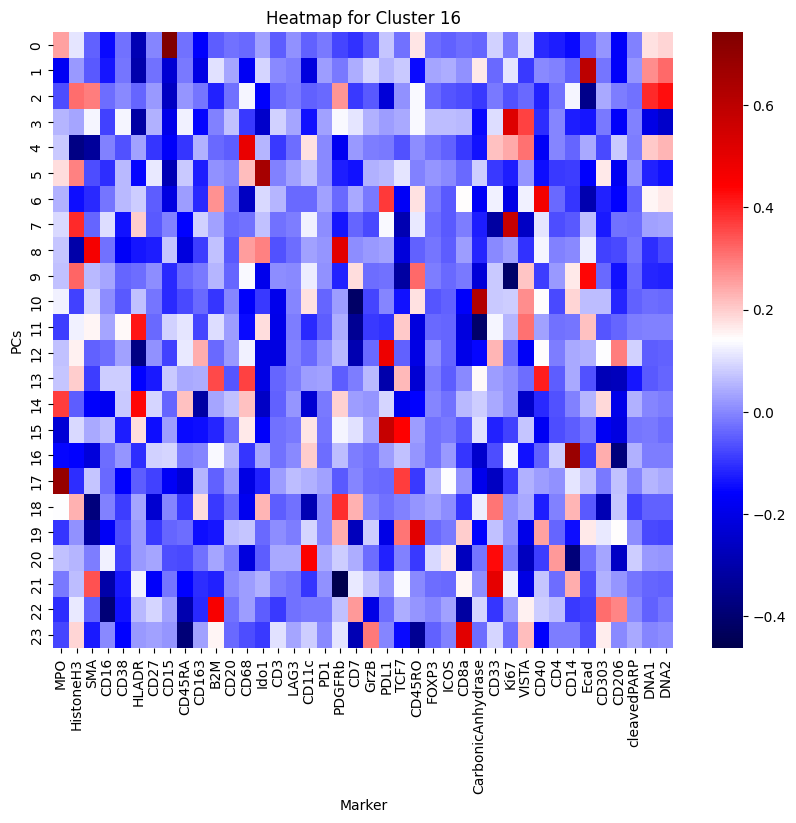

In [36]:
### 4. Cluster analysis ###
## PCA on each cluster ##


for i in range(model_cellcharter.best_k):
  mask = train_anndata.obs['clusters_cellcharter'] == i

  cluster_exprs = train_anndata.layers['exprs_norm'][mask,:]
  pca = PCA(n_components = 0.95, svd_solver='full')
  cluster_exprs_pca = pca.fit_transform(cluster_exprs)

  plt.figure(figsize=(10, 8))
  sns.heatmap(pca.components_, cmap="seismic", xticklabels=train_anndata.var['marker'])
  plt.title(f'Heatmap for Cluster {i}')
  plt.xlabel('Marker')
  plt.ylabel('PCs')
  plt.show()





We observe that the number of principal components required to explain 95% of the variance varies across clusters. There are clusters explained by fewer than 23 PCs (comparing to Ex.1). Additionally, marker contributions differ between clusters; however, certain markers consistently have a strong influence on the principal components across multiple clusters.

In [37]:
## 4.2 The average cell type abundance in each cluster ##
celltype_abundance = train_anndata.obs.groupby(['clusters_cellcharter', 'celltypes']).size().unstack()

celltype_avg_abundance = celltype_abundance.div(celltype_abundance.sum(axis=1), axis=0)
celltype_avg_abundance



<ipython-input-37-6c591d7abed1>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  celltype_abundance = train_anndata.obs.groupby(['clusters_cellcharter', 'celltypes']).size().unstack()


celltypes,B,BnT,CD4,CD8,DC,HLADR,MacCD163,Mural,NK,Neutrophil,Treg,Tumor,pDC,plasma
clusters_cellcharter,,,,,,,,,,,,,,
0,0.000937,0.001100,0.089728,0.142595,0.042441,0.023460,0.078242,0.246945,0.005987,0.001426,0.075920,0.148338,0.005376,0.137504
1,0.000000,0.000000,0.000000,0.000285,0.002845,0.000000,0.000142,0.000000,0.000000,0.002703,0.000000,0.994025,0.000000,0.000000
2,0.000471,0.000000,0.001473,0.000000,0.004773,0.003830,0.003536,0.001414,0.000000,0.010784,0.001120,0.971892,0.000059,0.000648
3,0.000428,0.000086,0.080873,0.067351,0.059050,0.032007,0.276594,0.048695,0.007274,0.021994,0.043817,0.347197,0.006076,0.008558
4,0.000072,0.000000,0.002018,0.021042,0.000865,0.002450,0.002378,0.000072,0.000000,0.007278,0.000360,0.963465,0.000000,0.000000
5,0.100489,0.059426,0.190486,0.237250,0.023659,0.031428,0.107905,0.116834,0.013822,0.000858,0.045553,0.003229,0.016799,0.052263
6,0.000535,0.000297,0.044166,0.126018,0.018308,0.004696,0.040421,0.000357,0.000416,0.034358,0.041372,0.684896,0.002913,0.001248
7,0.000162,0.000081,0.019916,0.058695,0.011496,0.048170,0.034812,0.054566,0.004372,0.006962,0.001943,0.757691,0.000081,0.001052
8,0.000781,0.000390,0.016201,0.070467,0.018446,0.015128,0.064513,0.030646,0.003416,0.027230,0.003318,0.740874,0.000098,0.008491


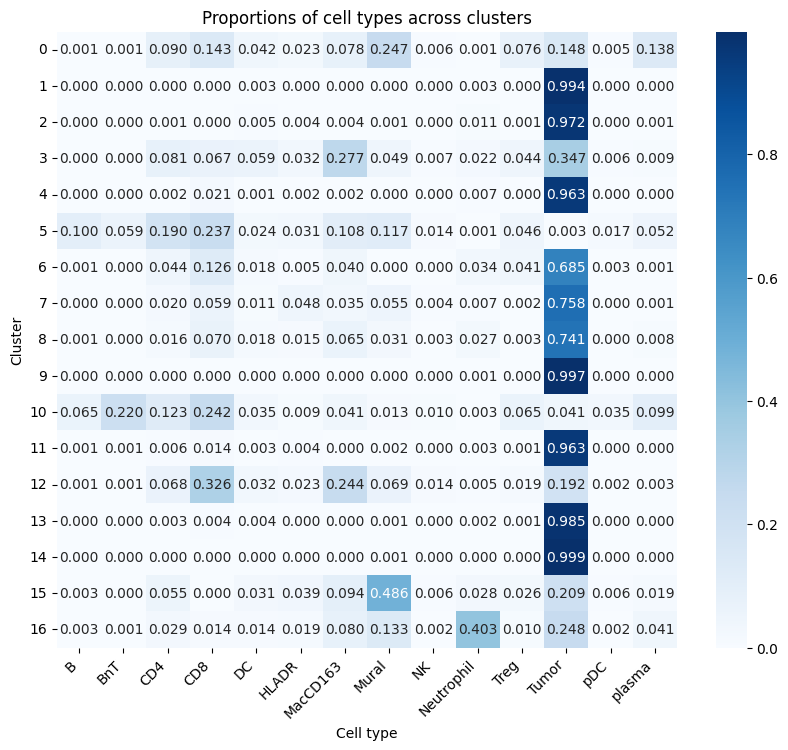

In [39]:
# Heatmap for the average cell type abundance
plt.figure(figsize=(10,8))
sns.heatmap(celltype_avg_abundance, annot=True,fmt='.3f', cmap="Blues")

plt.title('Proportions of cell types across clusters')
plt.xlabel('Cell type')
plt.ylabel('Cluster')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.show()

In almost every cluster, cancer cells are highly dominant, which is understandable given that the samples were collected from cancer patients. Interestingly, in cluster 16, we observe the highest proportion of neutrophils compared to the other clusters, while the proportion of tumor cells is much lower. This may suggest that the tumor has been expelled, or it could indicate a specific region of the tumor.

In [40]:
# Count mean marker for each cluster

clusters_avg_exprs = []
for i in range(model_cellcharter.best_k):
  mask = train_anndata.obs['clusters_cellcharter'] == i
  ids = np.where(mask)[0]

  cluster_exprs = train_anndata.layers['exprs'][ids]
  clusters_avg_exprs.append(cluster_exprs.mean(axis=0))

clusters_avg_exprs_df = pd.DataFrame(clusters_avg_exprs, columns=train_anndata.var['marker'])
clusters_avg_exprs_df


marker,MPO,HistoneH3,SMA,CD16,CD38,HLADR,CD27,CD15,CD45RA,CD163,...,VISTA,CD40,CD4,CD14,Ecad,CD303,CD206,cleavedPARP,DNA1,DNA2
0,0.212951,2.949114,1.016910,1.094006,0.737759,2.284984,1.078746,0.737450,0.750027,0.732596,...,1.125962,1.114587,1.716097,2.678192,2.265243,1.153107,0.822132,0.217270,4.605493,5.165684
1,0.159093,2.502447,0.327952,0.266891,0.275942,0.667529,0.377183,0.691194,0.547553,0.153032,...,0.211282,0.195330,1.257028,1.740913,4.408815,0.617444,0.498874,0.192910,4.388831,4.958443
2,0.208750,3.320149,0.519973,0.465480,0.379154,1.313406,0.700466,0.667833,0.707078,0.273882,...,0.678193,0.806510,1.479013,2.615125,4.372592,1.255704,0.553444,0.311659,4.694234,5.259944
3,0.275144,2.380360,0.445191,1.427752,0.364456,2.991007,0.727991,1.400695,0.460361,1.640330,...,1.147173,1.462473,1.891907,3.241628,2.329734,0.863758,1.459584,0.162513,4.086107,4.645526
4,0.192492,2.539630,0.128022,0.335334,0.321644,1.270734,0.534210,3.401644,0.443076,0.225873,...,0.542124,0.450516,1.133577,1.893849,3.893635,0.802718,0.450422,0.269887,4.272777,4.834241
5,0.180612,2.337311,0.472670,0.721665,0.418278,2.603284,0.975726,0.614296,0.939954,0.953243,...,1.012763,1.007010,1.825956,2.533085,1.112986,0.950684,1.053845,0.145988,4.526977,5.093630
6,0.319469,2.922014,0.357705,1.400709,0.723248,3.431448,1.060902,1.882023,0.811178,0.846194,...,1.258402,1.755465,1.860608,2.906900,3.837772,1.350929,0.890405,0.379786,4.556950,5.116099
7,0.183524,2.038476,0.345264,0.428940,0.161681,1.790467,0.381986,1.809540,0.301228,0.311965,...,0.608049,0.690120,0.897783,1.892260,1.223273,0.629042,0.470202,0.087376,4.173361,4.735083
8,0.253789,2.406802,0.197019,1.110354,0.427189,2.219912,0.675362,1.527331,0.460523,0.653339,...,1.179439,1.327539,1.398040,2.862522,1.705194,0.947632,0.699750,0.157781,4.345589,4.912442
9,0.146623,2.386136,0.150934,0.321803,0.313129,0.616422,0.471987,0.932250,0.687497,0.164179,...,0.420278,0.363633,1.210674,2.103444,3.578662,0.791597,0.541636,0.383103,4.395877,4.960578


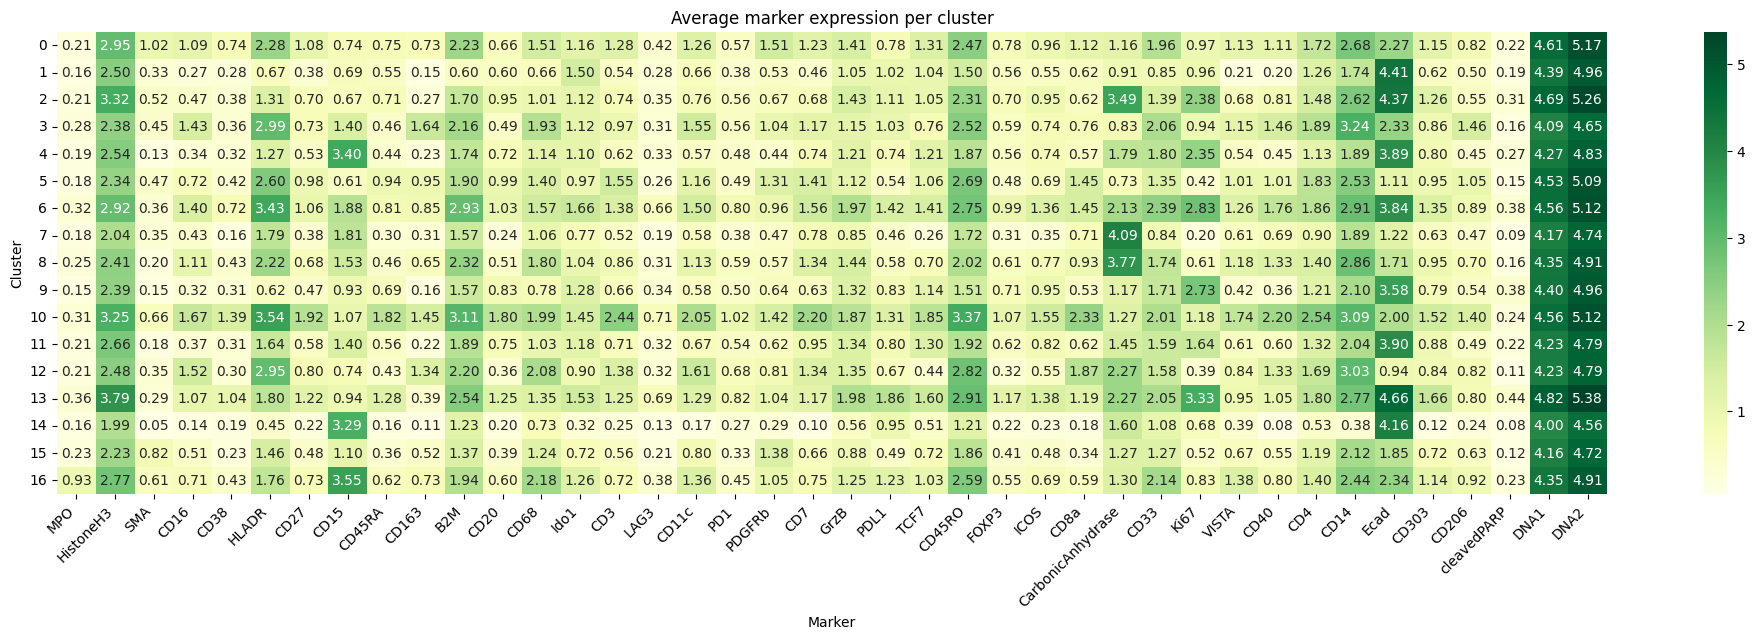

In [47]:
# Heatmap for markers' means for each cluster

plt.figure(figsize=(25,6))
sns.heatmap(clusters_avg_exprs_df, annot=True, fmt='.2f', cmap="YlGn")

plt.title('Average marker expression per cluster')
plt.xlabel('Marker')
plt.ylabel('Cluster')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.show()

We observe that the highest average expression across all clusters is for DNA1 and DNA2. Some markers show varying expression across clusters; for example, Ecad has the highest expression in cluster 13 and the lowest in cluster 12. Additionally, there are markers with consistently low expression, such as cleaved PARP.

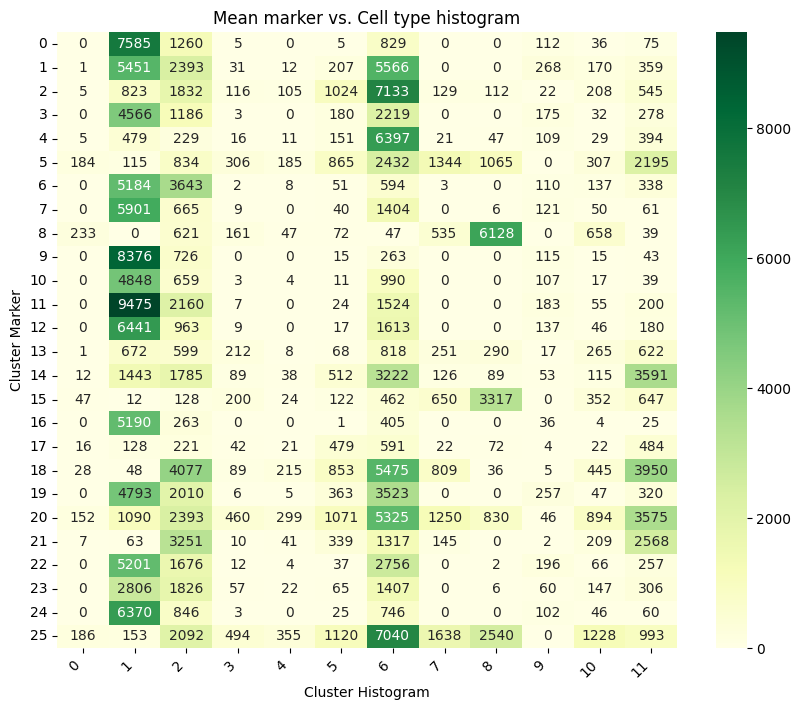

In [54]:
### Cross-count Matrices ###

# mean marker vs. cell type histogram
markers_hists_cross_count = pd.crosstab(train_anndata.obs['clusters_avg_marker_exps'], train_anndata.obs['clusters_hists'])

plt.figure(figsize=(10,8))
sns.heatmap(markers_hists_cross_count, annot=True, fmt='d', cmap="YlGn")

plt.title('Mean marker vs. Cell type histogram')
plt.xlabel('Cluster Histogram')
plt.ylabel('Cluster Marker')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.show()

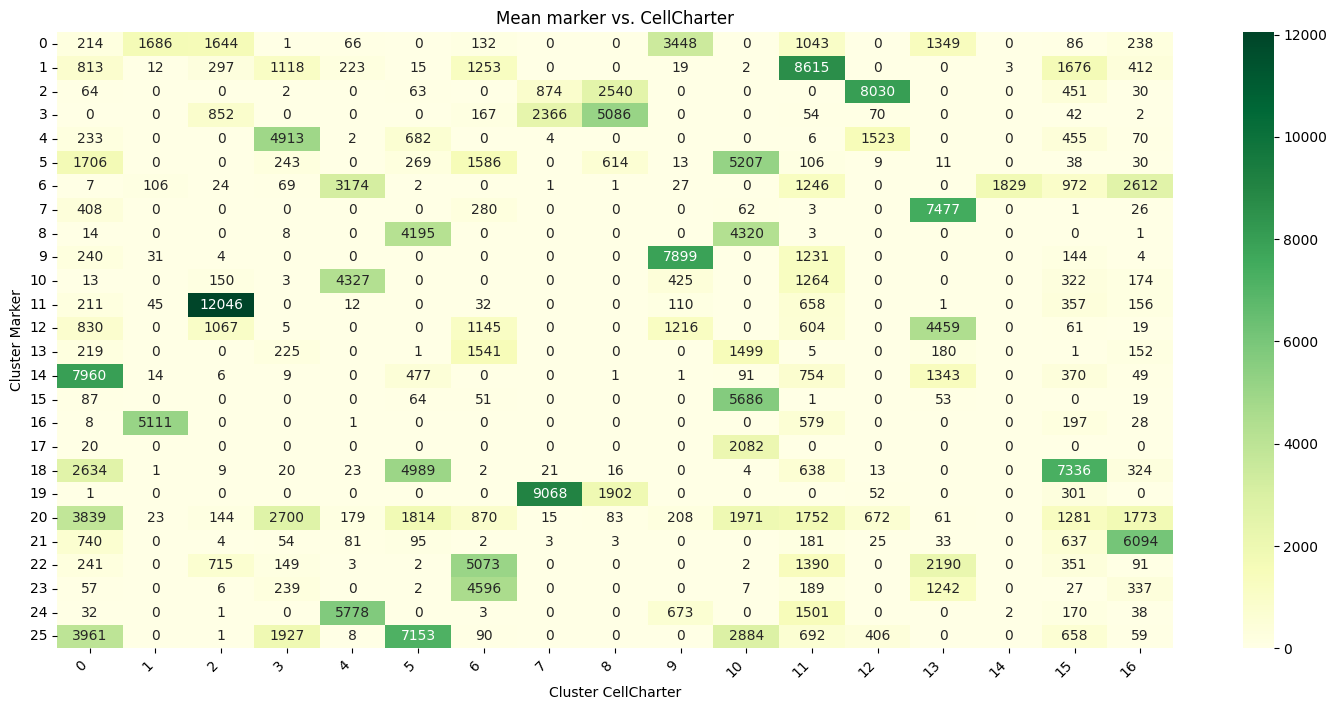

In [53]:
# mean marker vs. CellCharter
markers_cellcharter_cross_count = pd.crosstab(train_anndata.obs['clusters_avg_marker_exps'], train_anndata.obs['clusters_cellcharter'])

plt.figure(figsize=(18,8))
sns.heatmap(markers_cellcharter_cross_count, annot=True, fmt='d', cmap="YlGn")

plt.title('Mean marker vs. CellCharter')
plt.xlabel('Cluster CellCharter')
plt.ylabel('Cluster Marker')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.show()


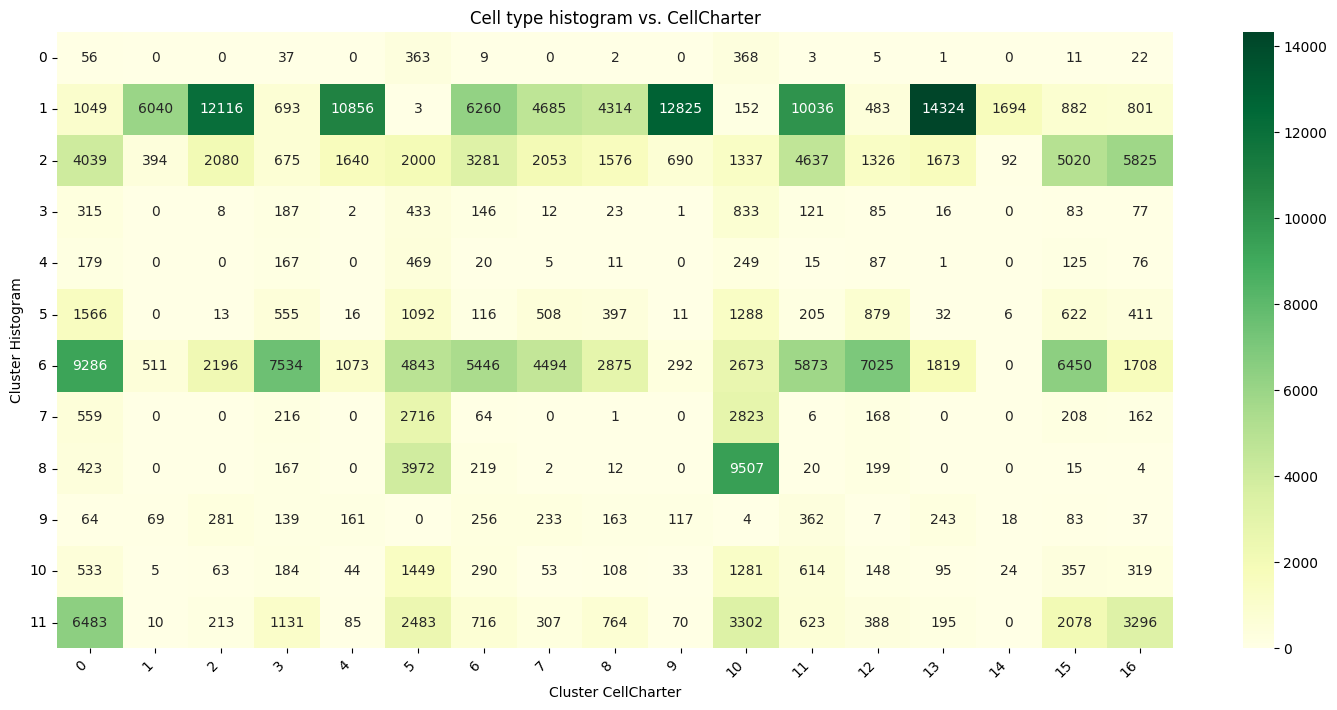

In [52]:
# cell type histogram vs. CellCharter
hists_cellcharter_cross_count = pd.crosstab(train_anndata.obs['clusters_hists'], train_anndata.obs['clusters_cellcharter'])

plt.figure(figsize=(18,8))
sns.heatmap(hists_cellcharter_cross_count, annot=True, fmt='d', cmap="YlGn")

plt.title('Cell type histogram vs. CellCharter')
plt.xlabel('Cluster CellCharter')
plt.ylabel('Cluster Histogram')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.show()

We observe significant mismatches between the two clustering results in all three cross-count matrices. However, in mean marker vs. cell type histogram clusters 1 and 6 of cell type histograms show a high degree of agreement with the clusters based on marker mean expression. The rest shows low consistency.

In mean marker vs. CellCharter we can also observe few clusters that align with each other, for instance cluster 11 from marker and 2 from CellCharter. However, there is considerable disagreement overall.

In cell type histogram vs. CellCharter we see the similar pattern, few clusters align, similar as for mean marker vs. cell type histogram - cluster 1 and 6 from histogram.

These results suggest that the influence of cell type and marker expression of neighboring cells affects the cells in different ways.